<a href="https://colab.research.google.com/github/androbaza/IP-algos/blob/main/4_Homomorphic_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
from imageio import imread
import matplotlib.pyplot as plt

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage.filters import convolve
from skimage.draw import circle
from skimage.transform import resize
from functools import partial

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(512, 512)


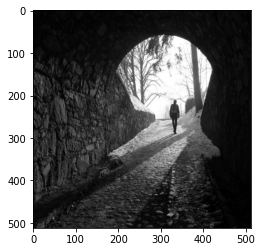

In [77]:
im = imread("/content/drive/MyDrive/samples/bridge.jpg", pilmode="L")
im = resize(im, (512, 512), order=1, anti_aliasing=True, mode="reflect") 
im = (im*255).astype(np.uint8)
plt.imshow(im, vmax=255, vmin=0, cmap="gray")
print(im.shape)
plt.show()

# Exercise 4: Filtering in Frequency Domain

The discrete Fourier transform (DFT) represents an image as a sum of sine and cosine waves with different frequencies and amplitudes. It is defined as:

$$
F(u,v) = \sum_{x=0}^{M}\sum_{y=0}^{N}f(x,y) \cdot e^{-2i\pi\cdot\left(\dfrac{u \cdot x}{M} + \dfrac{v \cdot y}{N} \right)} \;.
$$

This equation makes use of [Euler's formula](https://en.wikipedia.org/wiki/Euler%27s_formula) to represent the base function of the transform:

$$
e^{i \cdot x} = \mathrm{cos}(x) + i\cdot \mathrm{sin}(x) \;.
$$

The result is an array of complex numbers $F(u,v)$, each encoding the parameters of a wave with horizontal frequency $u$ and vertical frequency $v$. The absolute value of that number encodes the *amplitude* of that wave and its argument (the angle between the coefficients of the complex number) encodes the *phase* (offset) of the wave.

For a more extensive explanation, please refer to [this page](https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm).

## Task 4 - Homomorphic Filtering

An image $F$ can be modelled as the product of *illumination* $I$ and *reflectance* $R$: $F(i,j) = I(i,j) \cdot R(i,j)$.

Homomorphic filtering aims at homogenizing uneven illumination across the image and increasing the influence of reflectance to highlight details. To do this, we transform the image into the log space, so that the product becomes a sum:

$$\log F(i,j) = \log I(i,j) + \log R(i,j)$$

The intuition for the next step is, that illumination changes slowly (= low frequencies), while reflectance changes quickly (= high frequency). Thus, we apply a high-pass filter in the log space to highlight reflectance and suppress changes of illumination.

Implement a function that performs homomorphic filtering to an image. Visualize the results and test your implementation with different images!

In [90]:
def gauss_filter(size, sigma=1):
    """ Creates gaussian kernel with a given size and sigma. """
    ax = np.arange(np.ceil(-size / 2), np.ceil(size / 2))
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    return kernel / kernel.sum()


def homomorphic_filter(im, radius_ratio=0.2, l=0.2):
    
    radius = int(min(im.shape) * radius_ratio)
    
    if im.dtype == np.uint8:
        im = im.astype(np.float) / 255
    # im = im.astype(np.float) / 255
    log_im = np.log1p(im) # TODO: transfer the image to log-space
    # plt.imshow(log_im)
    I = fftshift(fft2(log_im))
    
    # create a low pass filter
    pass_mask = gauss_filter(min(im.shape), radius)
    
    # convert to high pass filter
    pass_mask2 = 1 - pass_mask
    
    # normalize to [0..1] 
    pass_mask = (pass_mask2 - np.min(pass_mask2)) / ((np.max(pass_mask2)) - np.min(pass_mask2))
    # print(pass_mask)
    # pass_mask = normalize(pass_mask)
    
    # scale to [l .. 1] ([0 .. 1] -> [0 .. 1-l] -> [l .. 1])
    pass_mask *= 1 - l
    pass_mask += l
    plt.imshow(pass_mask, cmap=plt.cm.gray)
    
    res = (ifft2(ifftshift(I * pass_mask))).real
    # plt.imshow(res, cmap=plt.cm.gray)
    res = np.exp(res) # TODO: transfer back from log-space
    
    # Re-normalize the image
    res -= res.min()
    res /= res.max()
    return res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


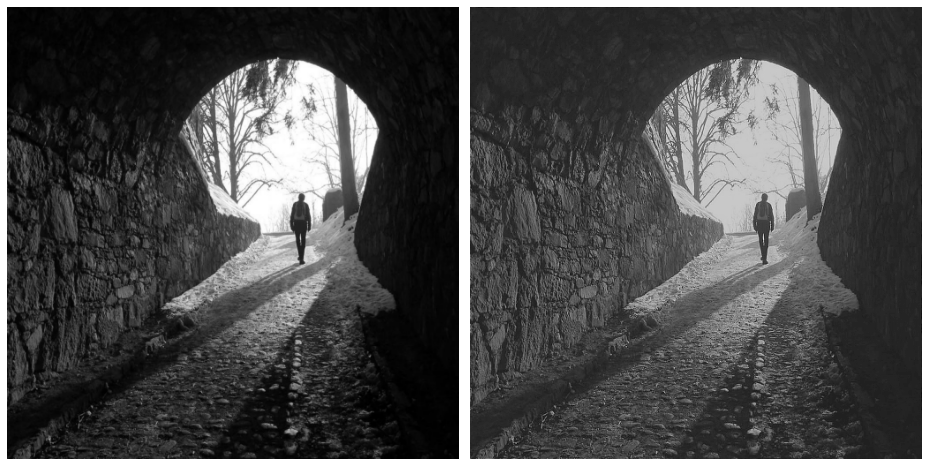

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(13, 9))
for ax in axs:
    ax.axis('off')

im0 = homomorphic_filter(im, 0.8, 0.2)

axs[0].imshow(im, vmin=0, vmax=255, cmap=plt.cm.gray)
axs[1].imshow(im0, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()